# **Blood Cell Classification**

**Table of Content:**

1. [Setup](#setup)

2. [Preprocessing](#preprocessing)

3. [Image Normalization](#image-normalization)

## Setup

1. **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, transform, feature, color, filters, measure, morphology
from scipy import stats
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

2. **Identifying Paths and Classes**

In [2]:
BloodCells = '../Data/main/bloodcells_dataset'
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

3. **Loading Image Files**

In [3]:
def get_image_files(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

## Preprocessing

1. **Counting Images in Each Class**

In [4]:
counts = {}
for cell_type in cell_types:
    folder_path = os.path.join(BloodCells, cell_type)
    image_files = get_image_files(folder_path)
    counts[cell_type] = len(image_files)

print("Number of images per cell type:\n")
for cell_type, count in counts.items():
    print(f"{cell_type}: {count}")

Number of images per cell type:

basophil: 1168
eosinophil: 3067
erythroblast: 1499
ig: 2744
lymphocyte: 1164
monocyte: 1370
neutrophil: 3279
platelet: 2348


2. **Validating Image Sizes**

In [5]:
# Count images that do NOT have the shape (363, 360, 3) for each cell type
non_standard_counts = {}
target_shape = (363, 360, 3)

for cell_type in cell_types:
    folder_path = os.path.join(BloodCells, cell_type)
    image_files = get_image_files(folder_path)
    non_standard_count = 0
    for fname in image_files:
        image = io.imread(os.path.join(folder_path, fname))
        if image.shape != target_shape:
            non_standard_count += 1
    non_standard_counts[cell_type] = non_standard_count

print("Number of inconsistant images:\n")
for cell_type, count in non_standard_counts.items():
    print(f"{cell_type}: {count}")


Number of inconsistant images:

basophil: 0
eosinophil: 0
erythroblast: 0
ig: 0
lymphocyte: 0
monocyte: 0
neutrophil: 0
platelet: 0


3. **Removing Inconsistencies**

In [6]:
for cell_type in cell_types:
    folder_path = os.path.join(BloodCells, cell_type)
    image_files = get_image_files(folder_path)
    
    for fname in image_files:
        file_path = os.path.join(folder_path, fname)
        image = io.imread(file_path)
        if image.shape != target_shape:
            os.remove(file_path)

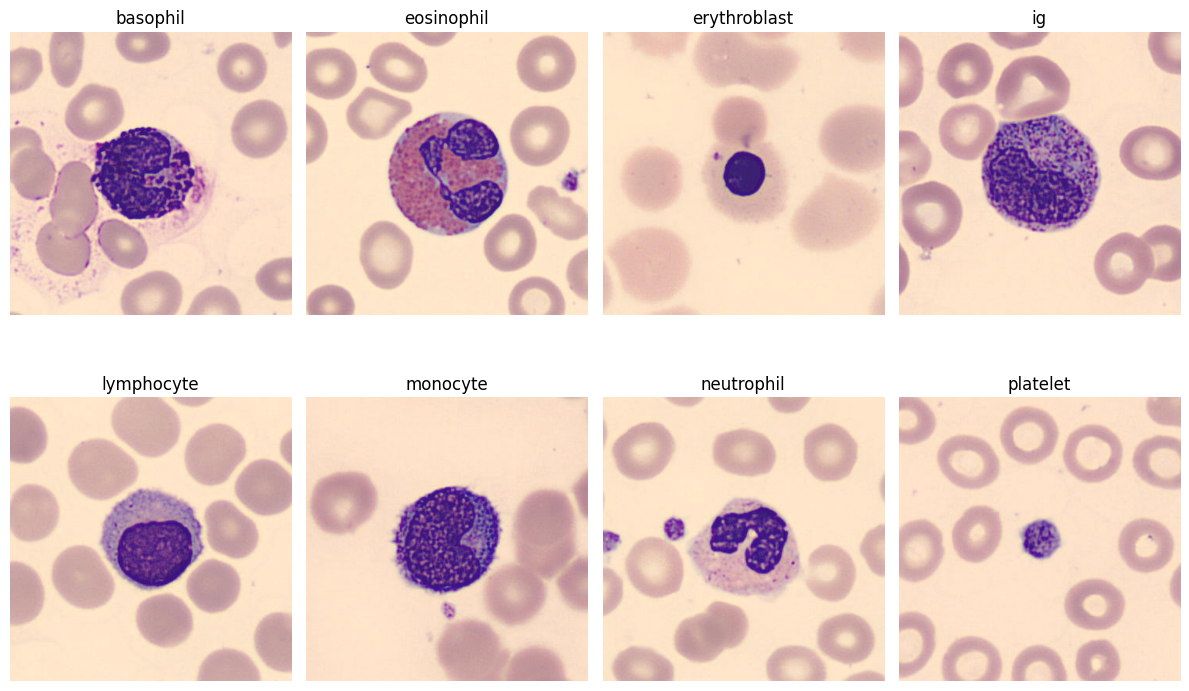

In [7]:
plt.figure(figsize=(12, 8))
for i, cell_type in enumerate(cell_types):
    folder_path = os.path.join(BloodCells, cell_type)
    image_files = get_image_files(folder_path)
    
    if image_files:
        sample_image_path = os.path.join(folder_path, image_files[0])
        image = io.imread(sample_image_path)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(image)
        plt.title(cell_type)
        plt.axis('off')

plt.tight_layout()
plt.show()

## Image Normalization

1. **Defining Normalization Function**

In [8]:
def imNormalize(image):
    if len(image.shape) == 2:  # grayscale image
        r = image
        g = image
        b = image
    else:
        r = image[:, :, 0]
        g = image[:, :, 1]
        b = image[:, :, 2]
    
    # Normalize each channel individually
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r, g, b), axis=2)

## Classical Feature Extraction

### **Morphological**

In [9]:
def extractMorphological(gray):
    # Binarize using Otsu's threshold
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    binary = morphology.remove_small_objects(binary, min_size=100)
    label_image = measure.label(binary)
    regions = measure.regionprops(label_image)
    if regions:
        region = max(regions, key=lambda r: r.area)
        features = {
            'area': region.area,
            'perimeter': region.perimeter,
            'eccentricity': region.eccentricity,
            'solidity': region.solidity,
            'extent': region.extent
        }
    else:
        features = {'area': np.nan, 'perimeter': np.nan, 'eccentricity': np.nan,
                    'solidity': np.nan, 'extent': np.nan}
    return features

### **Texture**

In [10]:
def extractTexture(gray):
    # Convert to uint8 in range [0,255]
    gray_uint8 = (gray * 255).astype(np.uint8)
    glcm = feature.graycomatrix(gray_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features = {
        'contrast': feature.graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': feature.graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': feature.graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': feature.graycoprops(glcm, 'energy')[0, 0],
        'correlation': feature.graycoprops(glcm, 'correlation')[0, 0],
        'ASM': feature.graycoprops(glcm, 'ASM')[0, 0]
    }
    return features

### **Color**

In [11]:
def extractColor(image):
    # Color histograms with 16 bins per channel
    hist_R, _ = np.histogram(image[:, :, 0], bins=16, range=(0, 255))
    hist_G, _ = np.histogram(image[:, :, 1], bins=16, range=(0, 255))
    hist_B, _ = np.histogram(image[:, :, 2], bins=16, range=(0, 255))
    
    # Normalize histograms
    hist_R = hist_R / np.sum(hist_R)
    hist_G = hist_G / np.sum(hist_G)
    hist_B = hist_B / np.sum(hist_B)
    
    # Color moments: mean, std, skewness for each channel
    moments = {
        'mean_R': np.mean(image[:, :, 0]),
        'std_R': np.std(image[:, :, 0]),
        'skew_R': stats.skew(image[:, :, 0].ravel()),
        'mean_G': np.mean(image[:, :, 1]),
        'std_G': np.std(image[:, :, 1]),
        'skew_G': stats.skew(image[:, :, 1].ravel()),
        'mean_B': np.mean(image[:, :, 2]),
        'std_B': np.std(image[:, :, 2]),
        'skew_B': stats.skew(image[:, :, 2].ravel())
    }
    
    # Combine histogram bins and moments into a single dictionary.
    features = {}
    for i, val in enumerate(hist_R):
        features[f'hist_R_bin{i}'] = val
    for i, val in enumerate(hist_G):
        features[f'hist_G_bin{i}'] = val
    for i, val in enumerate(hist_B):
        features[f'hist_B_bin{i}'] = val
    features.update(moments)
    
    return features

### **Edge**

In [12]:
def extractEdge(gray):
    edges = feature.canny(gray, sigma=1)
    edge_density = np.sum(edges) / edges.size
    return {'edge_density': edge_density}

### **Histogram of Oriented Gradients (HOG)**

In [13]:
def extractHOG(gray):
    hog_features, _ = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys',
                          visualize=True, feature_vector=True)
    # Return a dict with keys for each HOG feature
    features = {f'hog_{i}': val for i, val in enumerate(hog_features)}
    return features

## Extracting Features

Subsampling the dataset to reduce computation time.

In [14]:
# # Set a fixed random seed for reproducibility
# random.seed(450)

# # Create a dictionary to hold 500 selected image file names for each cell type
# image_files_dict = {}
# for cell_type in cell_types:
#     folder_path = os.path.join(BloodCells, cell_type)
#     all_files = get_image_files(folder_path)
#     if len(all_files) >= 500:
#         selected_files = random.sample(all_files, 500)
#     else:
#         selected_files = all_files
#     image_files_dict[cell_type] = selected_files
#     print(f"{cell_type}: {len(selected_files)} images selected.")

In [15]:
# def process_cell_type(cell_type, dataset_folder, image_files):
#     features_list = []
#     folder_path = os.path.join(dataset_folder, cell_type)
#     count = 1
#     for fname in image_files:
#         image_path = os.path.join(folder_path, fname)
#         print(f"Processing {count} of {len(image_files)}")
        
#         # Read the image using skimage.io
#         image = io.imread(image_path)
#         image = imNormalize(image)
#         gray = color.rgb2gray(image)
        
#         # Extract features using your defined functions
#         morph_feats = extractMorphological(gray)
#         texture_feats = extractTexture(gray)
#         color_feats = extractColor(image)
#         edge_feats = extractEdge(gray)
#         hog_feats = extractHOG(gray)
        
#         # Combine all features into one dictionary
#         features = {'cell_type': cell_type, 'filename': fname}
#         features.update(morph_feats)
#         features.update(texture_feats)
#         features.update(color_feats)
#         features.update(edge_feats)
#         features.update(hog_feats)
        
#         features_list.append(features)
#         count += 1
    
#     print("--------------------")
    
#     print(f"Finished processing {cell_type}.")
#     # Return a DataFrame for this cell type
#     return pd.DataFrame(features_list)

In [16]:
# for cell_type in cell_types:
#     print(f"Processing cell type: {cell_type}")
#     df = process_cell_type(cell_type, BloodCells, image_files_dict[cell_type])
#     csv_filename = f"{cell_type}_features.csv"
#     print(f"Saving {cell_type} features to {csv_filename}")
#     df.to_csv(csv_filename, index=False)

In [17]:
# # If you saved them, load them; otherwise, use the variables from the notebook.
# df_list = [
#     pd.read_csv('basophil_features.csv'),
#     pd.read_csv('eosinophil_features.csv'),
#     pd.read_csv('erythroblast_features.csv'),
#     pd.read_csv('ig_features.csv'),
#     pd.read_csv('lymphocyte_features.csv'),
#     pd.read_csv('monocyte_features.csv'),
#     pd.read_csv('neutrophil_features.csv'),
#     pd.read_csv('platelet_features.csv')
# ]

# # Concatenate all DataFrames into one
# features_df = pd.concat(df_list, ignore_index=True)

# # Optionally, save the combined DataFrame
# features_df.to_csv('features.csv', index=False)

In [18]:
# features_df.head()

In [19]:
features_df = pd.read_csv('features.csv')

## Classification

In [20]:
X = features_df.drop(['cell_type', 'filename'], axis=1)
y = features_df['cell_type']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Support Vector Machine (SVM)**

In [23]:
svm_model = SVC(kernel='rbf', random_state=450)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

    basophil       0.56      0.68      0.62       100
  eosinophil       0.48      0.53      0.50       100
erythroblast       0.79      0.55      0.65       100
          ig       0.32      0.24      0.27       100
  lymphocyte       0.70      0.77      0.73       100
    monocyte       0.52      0.74      0.61       100
  neutrophil       0.71      0.48      0.57       100
    platelet       0.90      0.93      0.92       100

    accuracy                           0.61       800
   macro avg       0.62      0.61      0.61       800
weighted avg       0.62      0.61      0.61       800



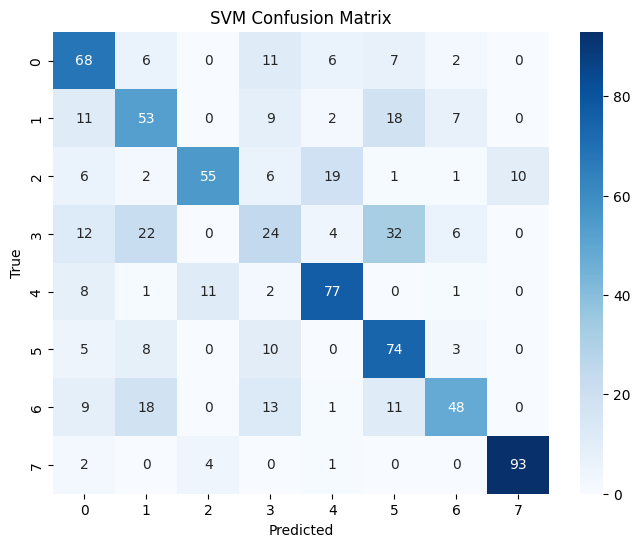

In [26]:
from sklearn.metrics import confusion_matrix


cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### **Random Forest**

In [ ]:
rf_model = RandomForestClassifier(random_state=450)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    basophil       0.68      0.82      0.75       100
  eosinophil       0.74      0.75      0.74       100
erythroblast       0.90      0.74      0.81       100
          ig       0.48      0.31      0.38       100
  lymphocyte       0.81      0.85      0.83       100
    monocyte       0.61      0.77      0.68       100
  neutrophil       0.86      0.84      0.85       100
    platelet       0.92      0.94      0.93       100

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



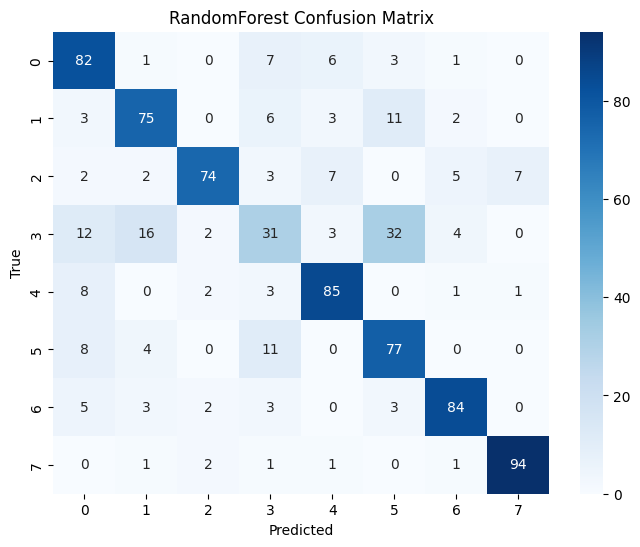

In [27]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()